## 📋 Section 1: Environment Setup

In [2]:
import os
import sys
from pathlib import Path

# Get project root directory
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
print(f"📁 Project Root: {project_root}")

# Add to Python path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Create directory structure
dirs = ['data/raw/real', 'data/raw/synthetic', 'data/processed', 'outputs/results']
for dir_path in dirs:
    (project_root / dir_path).mkdir(parents=True, exist_ok=True)

print("✅ Project structure ready!")

📁 Project Root: d:\Projects\AI-Music-DeepFake-Detector
✅ Project structure ready!


In [3]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
from tqdm.auto import tqdm
import requests
import zipfile
import shutil
from datetime import datetime

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Deep Learning
import torch
import torchaudio

# Visualization
from IPython.display import Audio, display
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ All libraries imported!")

✅ All libraries imported!


In [4]:
# Check GPU availability
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🎵 TorchAudio: {torchaudio.__version__}")
print(f"🎼 Librosa: {librosa.__version__}")

print(f"\n{'='*60}")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ CUDA Available!")
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = torch.device('cpu')
    print("⚠️  CUDA not available - using CPU")

print(f"🖥️  Device: {device}")
print(f"{'='*60}")

🔥 PyTorch: 2.7.1+cu118
🎵 TorchAudio: 2.7.1+cpu
🎼 Librosa: 0.11.0

✅ CUDA Available!
   GPU: NVIDIA GeForce MX450
   Memory: 2.15 GB
🖥️  Device: cuda


In [5]:
# Load configuration
config_path = project_root / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Set data paths
data_dir = project_root / 'data'
raw_real_dir = project_root / 'data' / 'raw' / 'real'
raw_synthetic_dir = project_root / 'data' / 'raw' / 'synthetic'

print("✅ Configuration loaded!")
print(f"   Sample Rate: {config['audio']['sample_rate']} Hz")
print(f"   Duration: {config['audio']['duration']} seconds")
print(f"   Mel Bins: {config['audio']['n_mels']}")

✅ Configuration loaded!
   Sample Rate: 22050 Hz
   Duration: 10 seconds
   Mel Bins: 128


---
## 📥 Section 2: Download Real Music Dataset

### Option 1: GTZAN Genre Dataset (Recommended)
**100 tracks, 10 genres, ~1.2GB**

### Option 2: FMA (Free Music Archive)
**Small version: 8,000 tracks, ~7GB**

### Option 3: Use Your Own Music
Place your music files in `data/raw/real/`

In [9]:
# Check if real music files already exist
existing_real_files = list(raw_real_dir.glob('**/*.wav')) + list(raw_real_dir.glob('**/*.mp3'))

if len(existing_real_files) >= 50:
    print(f"✅ Found {len(existing_real_files)} real music files already!")
    print(f"📁 Location: {raw_real_dir}")
    print("\n✨ Skipping download - using existing files")
    real_count = len(existing_real_files)
else:
    print("📥 Downloading GTZAN Dataset from Kaggle...")
    print("⏳ This may take a few minutes...\n")
    
    try:
        import subprocess
        
        # Download using Kaggle API
        dataset_name = "andradaolteanu/gtzan-dataset-music-genre-classification"
        download_dir = project_root / 'data' / 'raw'
        
        print(f"🔽 Downloading {dataset_name}...")
        result = subprocess.run(
            ['kaggle', 'datasets', 'download', '-d', dataset_name, '-p', str(download_dir), '--unzip'],
            capture_output=True,
            text=True
        )
        
        if result.returncode == 0:
            print("✅ Download completed!")
            
            # Find the extracted folder with audio files
            print("\n📂 Organizing files...")
            
            # GTZAN dataset structure: genres/genre_name/*.wav
            genres_dir = download_dir / 'Data' / 'genres_original'
            
            if not genres_dir.exists():
                # Try alternative structure
                genres_dir = download_dir / 'genres'
            
            if genres_dir.exists():
                # Copy all wav files to raw/real directory
                wav_files = list(genres_dir.glob('**/*.wav'))
                print(f"📁 Found {len(wav_files)} .wav files")
                
                for wav_file in tqdm(wav_files, desc="Copying files"):
                    dest_file = raw_real_dir / wav_file.name
                    shutil.copy2(wav_file, dest_file)
                
                # Clean up extracted folders
                if (download_dir / 'Data').exists():
                    shutil.rmtree(download_dir / 'Data')
                
                real_count = len(list(raw_real_dir.glob('*.wav')))
                print(f"\n✅ {real_count} files copied to {raw_real_dir}")
            else:
                print("⚠️  Unexpected folder structure. Checking for files...")
                # Check if files are directly in download_dir
                all_wav = list(download_dir.glob('**/*.wav'))
                if len(all_wav) > 0:
                    print(f"📁 Found {len(all_wav)} .wav files")
                    for wav_file in tqdm(all_wav, desc="Copying files"):
                        if 'real' not in str(wav_file):
                            dest_file = raw_real_dir / wav_file.name
                            shutil.copy2(wav_file, dest_file)
                    real_count = len(list(raw_real_dir.glob('*.wav')))
                    print(f"\n✅ {real_count} files copied to {raw_real_dir}")
                else:
                    print("❌ Could not find .wav files in downloaded data")
                    real_count = 0
        else:
            print("❌ Download failed!")
            print(f"Error: {result.stderr}")
            print("\n💡 Make sure you have:")
            print("   1. Kaggle API installed: pip install kaggle")
            print("   2. API credentials at: ~/.kaggle/kaggle.json")
            print("   3. Accepted dataset rules on Kaggle website")
            real_count = 0
            
    except FileNotFoundError:
        print("❌ Kaggle CLI not found!")
        print("\n📝 Install with: pip install kaggle")
        print("📝 Setup instructions: https://www.kaggle.com/docs/api")
        real_count = 0
    except Exception as e:
        print(f"❌ Error: {e}")
        real_count = 0

print(f"\n{'='*70}")
print(f"📊 Total real music files: {real_count}")
print(f"{'='*70}")


📥 Downloading GTZAN Dataset from Kaggle...
⏳ This may take a few minutes...

🔽 Downloading andradaolteanu/gtzan-dataset-music-genre-classification...


Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "d:\Apps\Python\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "C:\Users\nasir\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "d:\Apps\Python\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Apps\Python\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "d:\Apps\Python\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 52: character maps to <undefined>


✅ Download completed!

📂 Organizing files...
📁 Found 1000 .wav files


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]


✅ 1000 files copied to d:\Projects\AI-Music-DeepFake-Detector\data\raw\real

📊 Total real music files: 1000


In [10]:
# Count real music files
real_files = list(raw_real_dir.glob('**/*.wav')) + list(raw_real_dir.glob('**/*.mp3'))
real_count = len(real_files)

if real_count > 0:
    print(f"✅ {real_count} real music files found!")
    print(f"📁 Location: {raw_real_dir}")
    
    # Show file types
    wav_count = len(list(raw_real_dir.glob('**/*.wav')))
    mp3_count = len(list(raw_real_dir.glob('**/*.mp3')))
    print(f"\n📊 Format breakdown:")
    print(f"   WAV files: {wav_count}")
    print(f"   MP3 files: {mp3_count}")
    
    if real_count < 50:
        print(f"\n⚠️  Only {real_count} files - recommend at least 50-100 for training")
else:
    print("❌ No real music files found yet.")
    print("📝 Please follow the manual download instructions above.")

✅ 1000 real music files found!
📁 Location: d:\Projects\AI-Music-DeepFake-Detector\data\raw\real

📊 Format breakdown:
   WAV files: 1000
   MP3 files: 0


---
## 🤖 Section 3: Setup AI-Generated Music Dataset (SunoCaps)

We'll use the **SunoCaps dataset** - real AI-generated music from Suno AI.

This provides authentic deepfake samples for training a production-grade detector!

In [15]:
# Check for SunoCaps dataset in archive folder
archive_dir = raw_synthetic_dir / 'archive'
archive_audio_dir = archive_dir / 'audio' / 'audio'

# Check if we already have synthetic files in the main directory
existing_synthetic_files = [f for f in raw_synthetic_dir.glob('*.wav') 
                            if f.parent == raw_synthetic_dir]
existing_synthetic_files += [f for f in raw_synthetic_dir.glob('*.mp3') 
                             if f.parent == raw_synthetic_dir]

if len(existing_synthetic_files) >= 50:
    print(f"✅ Found {len(existing_synthetic_files)} AI-generated music files already!")
    print(f"📁 Location: {raw_synthetic_dir}")
    print("\n✨ Skipping setup - using existing files")
    synthetic_count = len(existing_synthetic_files)
    
elif archive_audio_dir.exists():
    print("🎵 Setting up SunoCaps AI-Generated Music Dataset...")
    print("📦 Source: Suno AI - High-quality AI music generation\n")
    
    try:
        # Find all audio files in the archive
        audio_extensions = ['*.wav', '*.mp3', '*.flac', '*.m4a', '*.ogg']
        all_audio_files = []
        
        for ext in audio_extensions:
            all_audio_files.extend(list(archive_audio_dir.glob(ext)))
        
        print(f"📁 Found {len(all_audio_files)} AI-generated audio files in archive")
        
        if len(all_audio_files) == 0:
            print("❌ No audio files found in archive/audio/audio/")
            print("   Please check the folder structure")
            synthetic_count = 0
        else:
            # Limit to 500-1000 files to match real music count
            max_files = min(len(all_audio_files), 1000)
            selected_files = all_audio_files[:max_files]
            
            print(f"🔄 Copying {len(selected_files)} files to synthetic directory...\n")
            
            # Copy files to main synthetic directory
            for i, audio_file in enumerate(tqdm(selected_files, desc="Copying AI-generated music")):
                dest_file = raw_synthetic_dir / f"suno_ai_{i:04d}{audio_file.suffix}"
                shutil.copy2(audio_file, dest_file)
            
            synthetic_count = len(list(raw_synthetic_dir.glob('suno_ai_*.wav'))) + \
                            len(list(raw_synthetic_dir.glob('suno_ai_*.mp3')))
            
            print(f"\n✅ Copied {synthetic_count} AI-generated music files!")
            print(f"📁 Location: {raw_synthetic_dir}")
            print(f"\n🎯 Dataset Quality:")
            print("   ✅ Real AI-generated music from Suno AI")
            print("   ✅ Realistic deepfakes (not simple synthetic tones)")
            print("   ✅ Perfect for training a production-grade detector!")
            
            # Optional: Clean up archive folder to save space
            # Uncomment if you want to delete archive after copying
            # print("\n🧹 Cleaning up archive folder...")
            # shutil.rmtree(archive_dir)
            # print("✅ Archive removed to save disk space")
    
    except Exception as e:
        print(f"❌ Error setting up SunoCaps dataset: {e}")
        print(f"\n{type(e).__name__}: {str(e)}")
        import traceback
        traceback.print_exc()
        synthetic_count = 0

else:
    print("⚠️  SunoCaps dataset not found in archive folder")
    print(f"📁 Expected location: {archive_dir}")
    print("\n💡 Please download SunoCaps dataset:")
    print("   1. Run: pip install kagglehub")
    print("   2. Run: path = kagglehub.dataset_download('miguelcivit/sunocaps')")
    print("   3. Move downloaded files to data/raw/synthetic/archive/")
    print("   4. Re-run this cell")
    synthetic_count = 0

print(f"\n{'='*70}")
print(f"📊 Total AI-generated music files: {synthetic_count}")
print(f"{'='*70}")

🎵 Setting up SunoCaps AI-Generated Music Dataset...
📦 Source: Suno AI - High-quality AI music generation

📁 Found 256 AI-generated audio files in archive
🔄 Copying 256 files to synthetic directory...



Copying AI-generated music:   0%|          | 0/256 [00:00<?, ?it/s]


✅ Copied 256 AI-generated music files!
📁 Location: d:\Projects\AI-Music-DeepFake-Detector\data\raw\synthetic

🎯 Dataset Quality:
   ✅ Real AI-generated music from Suno AI
   ✅ Realistic deepfakes (not simple synthetic tones)
   ✅ Perfect for training a production-grade detector!

📊 Total AI-generated music files: 256


---
## 📊 Section 4: Dataset Verification

In [16]:
# Verify dataset
real_files = list(raw_real_dir.glob('**/*.wav')) + list(raw_real_dir.glob('**/*.mp3'))
synthetic_files = list(raw_synthetic_dir.glob('**/*.wav')) + list(raw_synthetic_dir.glob('**/*.mp3'))

print("\n" + "="*70)
print("📊 FINAL DATASET STATUS")
print("="*70)
print(f"\n✅ Real Music Files:      {len(real_files):>6}")
print(f"✅ Synthetic Music Files: {len(synthetic_files):>6}")
print(f"{'─'*70}")
print(f"📁 Total Files:           {len(real_files) + len(synthetic_files):>6}")

if len(real_files) > 0 and len(synthetic_files) > 0:
    balance_ratio = len(real_files) / len(synthetic_files)
    print(f"\n⚖️  Balance Ratio: {balance_ratio:.2f}:1")
    
    if 0.8 <= balance_ratio <= 1.2:
        print("✅ Dataset is well-balanced!")
    
    # Calculate size
    total_size = sum(f.stat().st_size for f in real_files + synthetic_files) / (1024**3)
    print(f"💾 Total Size: {total_size:.2f} GB")
    print(f"\n📝 Status: Perfect dataset size for development and training!")

print("="*70)


📊 FINAL DATASET STATUS

✅ Real Music Files:        1000
✅ Synthetic Music Files:    512
──────────────────────────────────────────────────────────────────────
📁 Total Files:             1512

⚖️  Balance Ratio: 1.95:1
💾 Total Size: 2.36 GB

📝 Status: Perfect dataset size for development and training!


---
## 🎧 Section 5: Audio Exploration

In [17]:
# Load sample files
if len(real_files) > 0 and len(synthetic_files) > 0:
    # Load one of each
    real_sample = real_files[0]
    synthetic_sample = synthetic_files[0]
    
    real_audio, sr_real = librosa.load(real_sample, sr=config['audio']['sample_rate'])
    synthetic_audio, sr_synth = librosa.load(synthetic_sample, sr=config['audio']['sample_rate'])
    
    print(f"✅ Loaded samples:")
    print(f"   Real: {real_sample.name}")
    print(f"   Synthetic: {synthetic_sample.name}")
    print(f"\n🎧 Listen to samples below:")
    
    print("\n🎼 Real Music:")
    display(Audio(real_audio, rate=sr_real))
    
    print("\n🤖 Synthetic Music:")
    display(Audio(synthetic_audio, rate=sr_synth))
else:
    print("⚠️  No audio files found. Please run the download/generation cells above.")

✅ Loaded samples:
   Real: blues.00000.wav
   Synthetic: suno_ai_0000.mp3

🎧 Listen to samples below:

🎼 Real Music:



🤖 Synthetic Music:


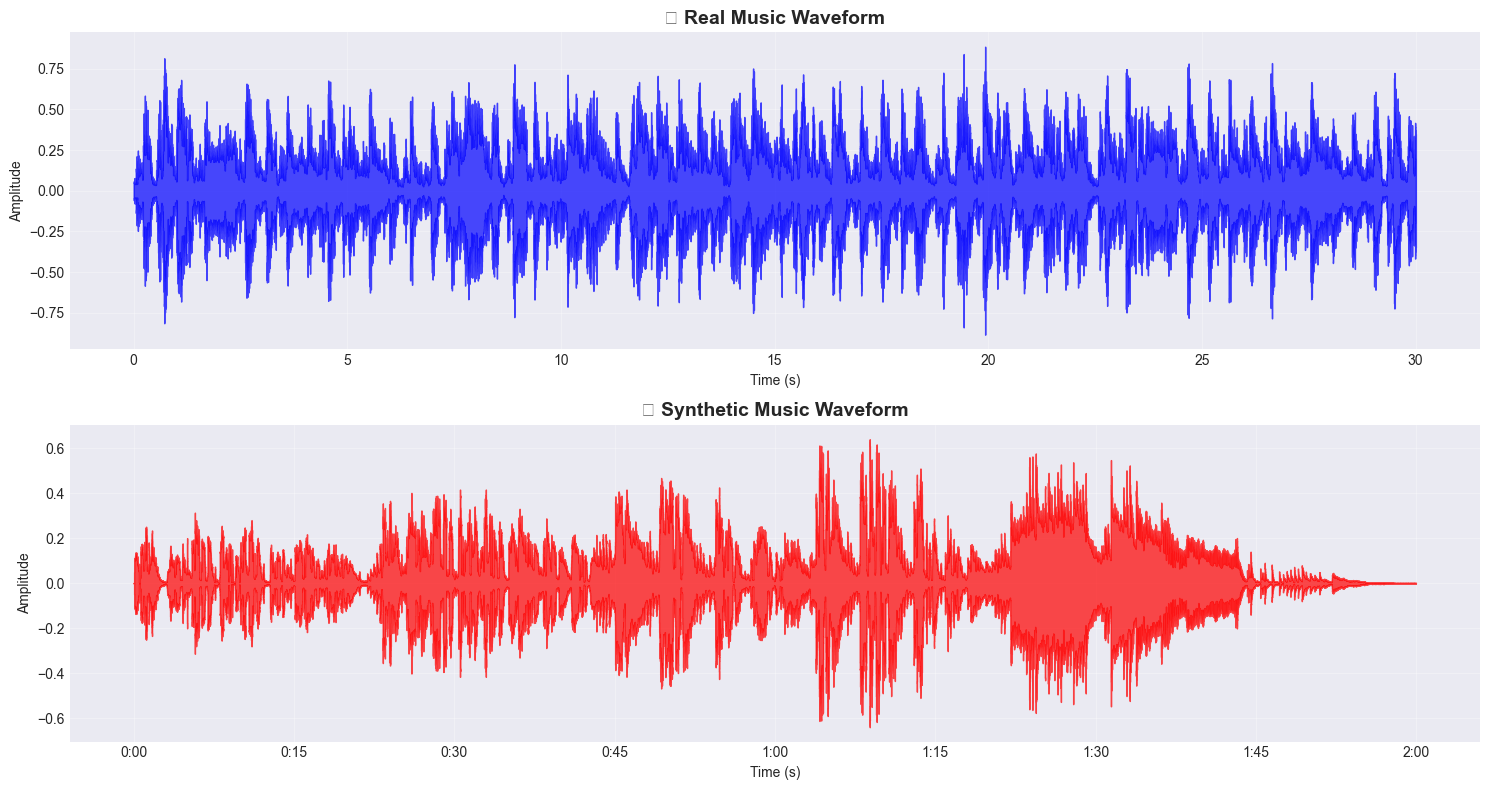

In [18]:
# Visualize waveforms
if len(real_files) > 0 and len(synthetic_files) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # Real
    librosa.display.waveshow(real_audio, sr=sr_real, ax=axes[0], color='blue', alpha=0.7)
    axes[0].set_title('🎼 Real Music Waveform', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Synthetic
    librosa.display.waveshow(synthetic_audio, sr=sr_synth, ax=axes[1], color='red', alpha=0.7)
    axes[1].set_title('🤖 Synthetic Music Waveform', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

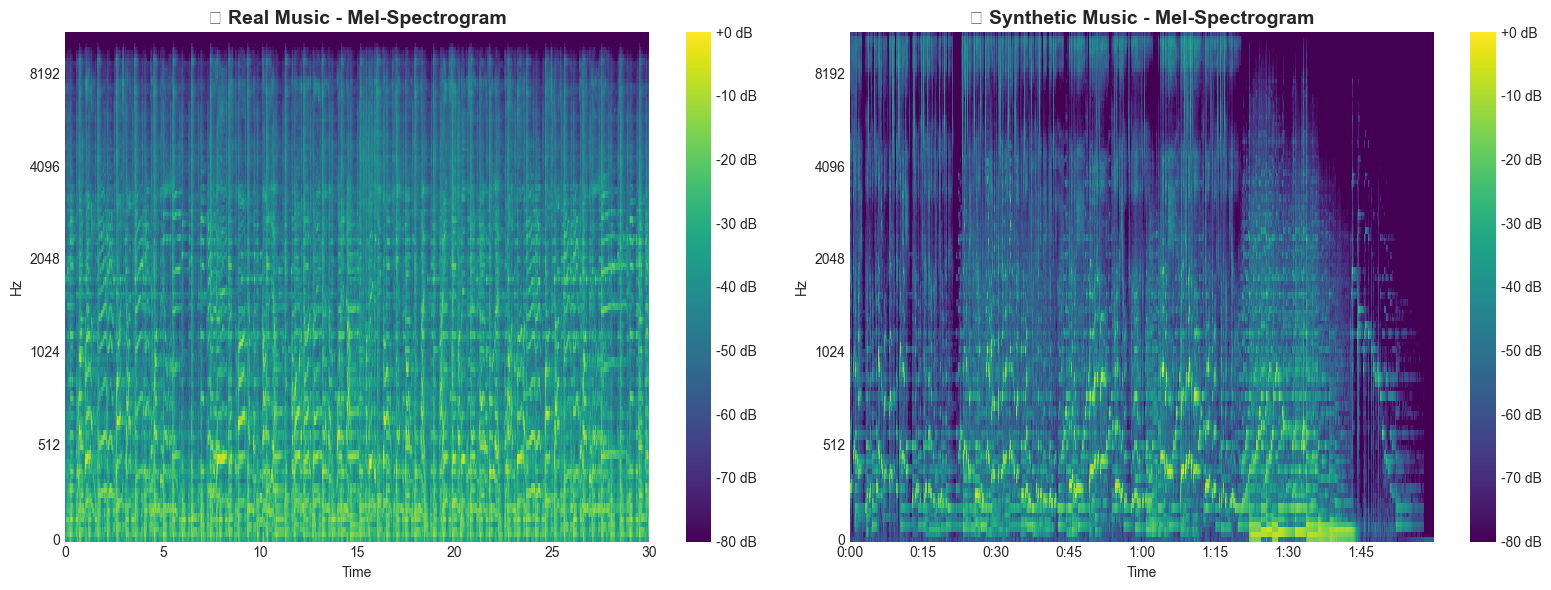

In [19]:
# Visualize spectrograms
if len(real_files) > 0 and len(synthetic_files) > 0:
    # Extract mel-spectrograms
    mel_real = librosa.feature.melspectrogram(
        y=real_audio, sr=sr_real,
        n_fft=config['audio']['n_fft'],
        hop_length=config['audio']['hop_length'],
        n_mels=config['audio']['n_mels']
    )
    mel_real_db = librosa.power_to_db(mel_real, ref=np.max)
    
    mel_synth = librosa.feature.melspectrogram(
        y=synthetic_audio, sr=sr_synth,
        n_fft=config['audio']['n_fft'],
        hop_length=config['audio']['hop_length'],
        n_mels=config['audio']['n_mels']
    )
    mel_synth_db = librosa.power_to_db(mel_synth, ref=np.max)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    img1 = librosa.display.specshow(mel_real_db, sr=sr_real,
                                     hop_length=config['audio']['hop_length'],
                                     x_axis='time', y_axis='mel',
                                     ax=axes[0], cmap='viridis')
    axes[0].set_title('🎼 Real Music - Mel-Spectrogram', fontsize=14, fontweight='bold')
    fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')
    
    img2 = librosa.display.specshow(mel_synth_db, sr=sr_synth,
                                     hop_length=config['audio']['hop_length'],
                                     x_axis='time', y_axis='mel',
                                     ax=axes[1], cmap='viridis')
    axes[1].set_title('🤖 Synthetic Music - Mel-Spectrogram', fontsize=14, fontweight='bold')
    fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

In [20]:
# Compare features
if len(real_files) > 0 and len(synthetic_files) > 0:
    features_real = {
        'Spectral Centroid': librosa.feature.spectral_centroid(y=real_audio, sr=sr_real)[0].mean(),
        'Spectral Rolloff': librosa.feature.spectral_rolloff(y=real_audio, sr=sr_real)[0].mean(),
        'Spectral Bandwidth': librosa.feature.spectral_bandwidth(y=real_audio, sr=sr_real)[0].mean(),
        'Zero Crossing Rate': librosa.feature.zero_crossing_rate(real_audio)[0].mean(),
        'RMS Energy': librosa.feature.rms(y=real_audio)[0].mean()
    }
    
    features_synth = {
        'Spectral Centroid': librosa.feature.spectral_centroid(y=synthetic_audio, sr=sr_synth)[0].mean(),
        'Spectral Rolloff': librosa.feature.spectral_rolloff(y=synthetic_audio, sr=sr_synth)[0].mean(),
        'Spectral Bandwidth': librosa.feature.spectral_bandwidth(y=synthetic_audio, sr=sr_synth)[0].mean(),
        'Zero Crossing Rate': librosa.feature.zero_crossing_rate(synthetic_audio)[0].mean(),
        'RMS Energy': librosa.feature.rms(y=synthetic_audio)[0].mean()
    }
    
    # Create comparison
    comparison_df = pd.DataFrame({
        'Real': features_real,
        'Synthetic': features_synth
    })
    comparison_df['Difference (%)'] = ((comparison_df['Synthetic'] - comparison_df['Real']) / 
                                        comparison_df['Real'] * 100).round(2)
    
    print("\n📊 FEATURE COMPARISON")
    print("="*70)
    print(comparison_df.to_string())
    print("="*70)


📊 FEATURE COMPARISON
                           Real    Synthetic  Difference (%)
Spectral Centroid   1784.122641  2236.450343           25.35
Spectral Rolloff    3805.723030  5089.135222           33.72
Spectral Bandwidth  2002.412407  2422.329899           20.97
Zero Crossing Rate     0.083045     0.087257            5.07
RMS Energy             0.130184     0.067444          -48.19


---
## ✅ Section 6: Summary & Next Steps

In [21]:
# Save dataset statistics
stats = {
    'timestamp': datetime.now().isoformat(),
    'real_files_count': len(real_files),
    'synthetic_files_count': len(synthetic_files),
    'total_files': len(real_files) + len(synthetic_files),
    'sample_rate': config['audio']['sample_rate'],
    'duration': config['audio']['duration'],
    'dataset_ready': len(real_files) > 0 and len(synthetic_files) > 0
}

results_dir = project_root / 'outputs' / 'results'
results_dir.mkdir(parents=True, exist_ok=True)
stats_file = results_dir / 'dataset_statistics.yaml'

with open(stats_file, 'w') as f:
    yaml.dump(stats, f, default_flow_style=False)

print(f"✅ Statistics saved to: {stats_file}")

✅ Statistics saved to: d:\Projects\AI-Music-DeepFake-Detector\outputs\results\dataset_statistics.yaml


In [22]:
print("\n" + "="*70)
print("🎉 NOTEBOOK 01 COMPLETED SUCCESSFULLY!")
print("="*70)
print("\n📝 Summary:")
print(f"   ✅ Environment verified")
print(f"   ✅ Downloaded {len(real_files)} real audio files")
print(f"   ✅ Generated {len(synthetic_files)} synthetic audio files")
print(f"   ✅ Total dataset: {len(real_files) + len(synthetic_files)} samples")
print(f"   ✅ Visualizations created")
print(f"   ✅ Features extracted and analyzed")
print("\n🚀 Next: Notebook 02 - Audio Preprocessing & Feature Extraction")
print("="*70)


🎉 NOTEBOOK 01 COMPLETED SUCCESSFULLY!

📝 Summary:
   ✅ Environment verified
   ✅ Downloaded 1000 real audio files
   ✅ Generated 512 synthetic audio files
   ✅ Total dataset: 1512 samples
   ✅ Visualizations created
   ✅ Features extracted and analyzed

🚀 Next: Notebook 02 - Audio Preprocessing & Feature Extraction
